Goals of the project: \
1.Extracting topics from research paper's abstracts and titles. \
2.Finding correlations of topics. \
3.Several visulization techniques to view extracted topics.


In [0]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


In [0]:
import warnings,logging
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Import Dataset

In [0]:
data = pd.read_csv('C:\\Users\\Divya\\Desktop\\Datafiles\\test\\testing')#Path of CSV file generated from Dataset
df = pd.DataFrame(data, columns= ['Title','Abstract'])
print(df.shape)  #> (2361, 3)
df.head()

(2577, 2)


,Title,Abstract
0,"Molecular dynamics simulations give insight into the conformational change, complex formation, a...",Cytochrome P450 reductase (CYPOR) undergoes a large conformational change to allow for an electr...
1,Generation of conditional lethal Candida albicans mutants by inducible deletion of essential genes.,The yeast Candida albicans is the most important fungal pathogen of humans and a model organism ...
2,[Interferon deficiency syndrome in children with lymphosarcoma].,The capacity of the peripheral blood mononuclears to produce leukocyte (alpha) and immune (gamma...
3,"Genomic structure, alternative maturation and tissue expression of the human BBOX1 gene.",Gamma-butyrobetaine hydroxylase (BBOX1) is the enzyme responsible for the biosynthesis of l-carn...
4,Representing infant feeding: content analysis of British media portrayals of bottle feeding and ...,To examine how breast feeding and bottle feeding are represented by the British media.


# Tokenize Sentences and Clean

In [0]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.Abstract.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['cytochrome', 'reductase', 'cypor', 'undergoes', 'large', 'conformational', 'change', 'to', 'allow', 'for', 'an', 'electron', 'transfer', 'to', 'redox', 'partner', 'to', 'take', 'place', 'after', 'an', 'internal', 'electron', 'transfer', 'over', 'its', 'cofactors', 'it', 'opens', 'up', 'to', 'facilitate', 'the', 'interaction', 'and', 'electron', 'transfer', 'with', 'cytochrome', 'the', 'open', 'conformation', 'appears', 'difficult', 'to', 'crystallize', 'therefore', 'model', 'of', 'human', 'cypor', 'in', 'the', 'open', 'conformation', 'was', 'constructed', 'to', 'be', 'able', 'to', 'investigate', 'the', 'stability', 'and', 'conformational', 'change', 'of', 'this', 'protein', 'by', 'means', 'of', 'molecular', 'dynamics', 'simulations', 'since', 'the', 'role', 'of', 'the', 'protein', 'is', 'to', 'provide', 'electrons', 'to', 'redox', 'partner', 'the', 'interactions', 'with', 'cytochrome', 'were', 'investigated', 'and', 'possible', 'complex', 'structure', 'is', 'suggested', 'additionall

In [0]:
#data_text = data[['Abstract']]
#data_text['index'] = data_text.index
#documents = data_text

# Build the Bigram, Trigram Models and Lemmatize

In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# Build the Topic Model

In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.027*"cell" + 0.011*"protein" + 0.010*"expression" + 0.008*"increase" + '
  '0.008*"tumor" + 0.007*"level" + 0.007*"induce" + 0.006*"show" + '
  '0.006*"brain" + 0.006*"response"'),
 (1,
  '0.012*"study" + 0.008*"model" + 0.007*"time" + 0.007*"base" + 0.007*"datum" '
  '+ 0.006*"research" + 0.005*"drug" + 0.005*"provide" + 0.005*"result" + '
  '0.005*"increase"'),
 (2,
  '0.034*"patient" + 0.009*"study" + 0.008*"high" + 0.008*"year" + '
  '0.008*"case" + 0.008*"treatment" + 0.007*"group" + 0.007*"risk" + '
  '0.007*"care" + 0.006*"age"'),
 (3,
  '0.009*"gene" + 0.007*"region" + 0.007*"genetic" + 0.006*"form" + '
  '0.005*"dna" + 0.005*"show" + 0.005*"analysis" + 0.005*"contain" + '
  '0.005*"structure" + 0.005*"process"')]


# What is the Dominant topic and its percentage contribution in each document


In [0]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.5305,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[cytochrome, reductase, cypor, undergoe, large, conformational, change, allow, electron, transfe..."
1,1,3.0,0.5442,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[yeast, candida, albican, important, fungal, pathogen, human, model, organism, study, fungal, vi..."
2,2,0.0,0.5485,"cell, protein, expression, increase, tumor, level, induce, show, brain, response","[capacity, mononuclear, produce, leukocyte, alpha, immune, gamma, interferon, well, interferon, ..."
3,3,3.0,0.5066,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[gamma, butyrobetaine, hydroxylase, bbox, enzyme, responsible, biosynthesis, carnitine, key, mol..."
4,4,3.0,0.5236,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[examine, breast, feeding, bottle, feeding, represent, british, medium]"
5,5,3.0,0.5774,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[truffl, hypogeous, fungus, live, symbiosis, plant, host, root, order, accomplish, life, cycle, ..."
6,6,2.0,0.7715,"patient, study, high, year, case, treatment, group, risk, care, age","[level, evidence, support, utility, cisplatin, base, chemotherapy, nac, muscle, invasive, bladde..."
7,7,2.0,0.4626,"patient, study, high, year, case, treatment, group, risk, care, age","[common, medical, condition, infant, belong, pediatric, disease, area, functional, disorder, foo..."
8,8,3.0,0.5563,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[quantum, ligand, dock, protein, ligand, dock, graphic, processing, unit, gpu, quantum, entangle..."
9,9,3.0,0.6244,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[channel, noise, dominant, intrinsic, noise, source, neuron, cause, variability, time, interspik..."


# What is the Dominant topic and its percentage contribution in each document

In [0]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)
#Code to extract dominant topics for correlation
#export_csv = df_dominant_topic.to_csv(r'C:\\Users\\Divya\\Desktop\\Datafiles\\test\\Correlation_topics_titles.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.5305,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[cytochrome, reductase, cypor, undergoe, large, conformational, change, allow, electron, transfe..."
1,1,3.0,0.5442,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[yeast, candida, albican, important, fungal, pathogen, human, model, organism, study, fungal, vi..."
2,2,0.0,0.5485,"cell, protein, expression, increase, tumor, level, induce, show, brain, response","[capacity, mononuclear, produce, leukocyte, alpha, immune, gamma, interferon, well, interferon, ..."
3,3,3.0,0.5066,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[gamma, butyrobetaine, hydroxylase, bbox, enzyme, responsible, biosynthesis, carnitine, key, mol..."
4,4,3.0,0.5236,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[examine, breast, feeding, bottle, feeding, represent, british, medium]"
5,5,3.0,0.5774,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[truffl, hypogeous, fungus, live, symbiosis, plant, host, root, order, accomplish, life, cycle, ..."
6,6,2.0,0.7715,"patient, study, high, year, case, treatment, group, risk, care, age","[level, evidence, support, utility, cisplatin, base, chemotherapy, nac, muscle, invasive, bladde..."
7,7,2.0,0.4626,"patient, study, high, year, case, treatment, group, risk, care, age","[common, medical, condition, infant, belong, pediatric, disease, area, functional, disorder, foo..."
8,8,3.0,0.5563,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[quantum, ligand, dock, protein, ligand, dock, graphic, processing, unit, gpu, quantum, entangle..."
9,9,3.0,0.6244,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[channel, noise, dominant, intrinsic, noise, source, neuron, cause, variability, time, interspik..."


# The most representative sentence for each topic

In [0]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9357,"cell, protein, expression, increase, tumor, level, induce, show, brain, response","[lumican, proteoglycan, overexpress, pancreatic, stellate, cell, pscs, pancreatic, ductal, adeno..."
1,1.0,0.9499,"study, model, time, base, datum, research, drug, provide, result, increase","[teacher, start, ditch, graph, calculator, math, app, expensive, tech, ever, worth, hold, studen..."
2,2.0,0.9329,"patient, study, high, year, case, treatment, group, risk, care, age","[sia, sue, fan, feel, lacklustre, show, pop, history, litter, live, disaster]"
3,3.0,0.9053,"gene, region, genetic, form, dna, show, analysis, contain, structure, process","[broad_spectrum, mercury, resistance, locus, mer, spontaneous, chloramphenicol, sensitive, cms, ..."


# Frequency Distribution of Word Counts in Documents

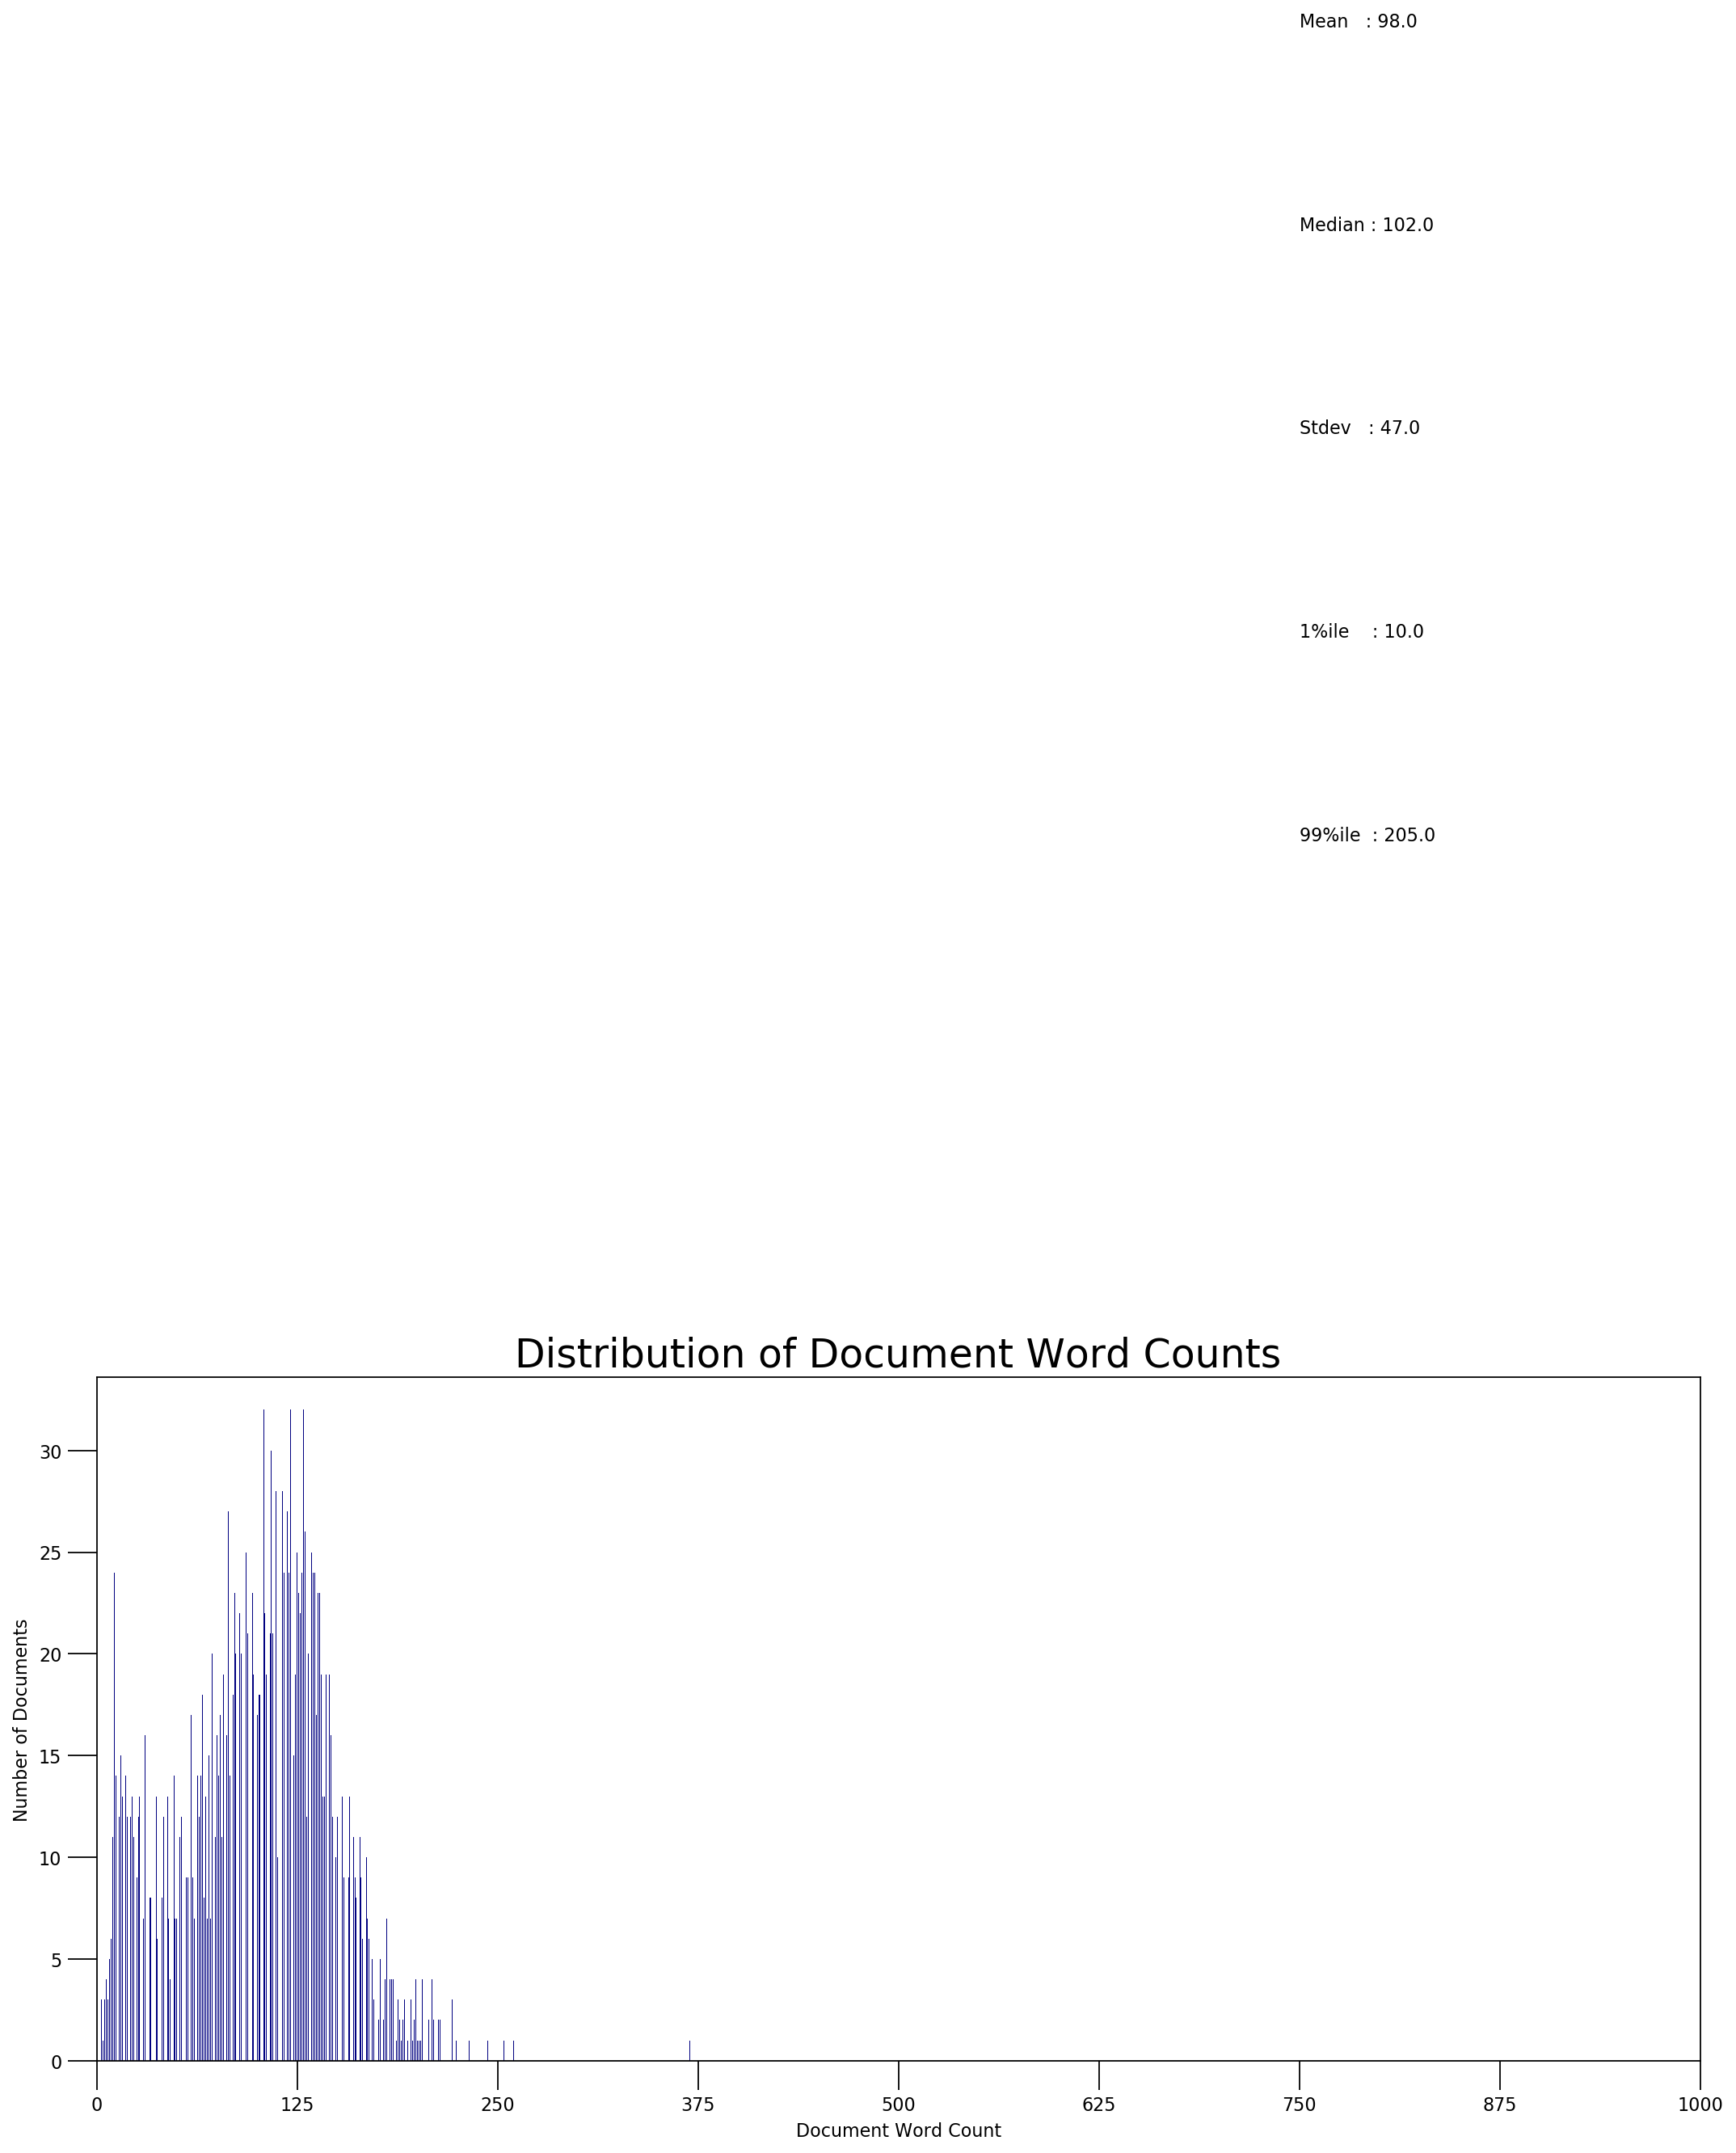

In [0]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

# 

C:\Users\Divya\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


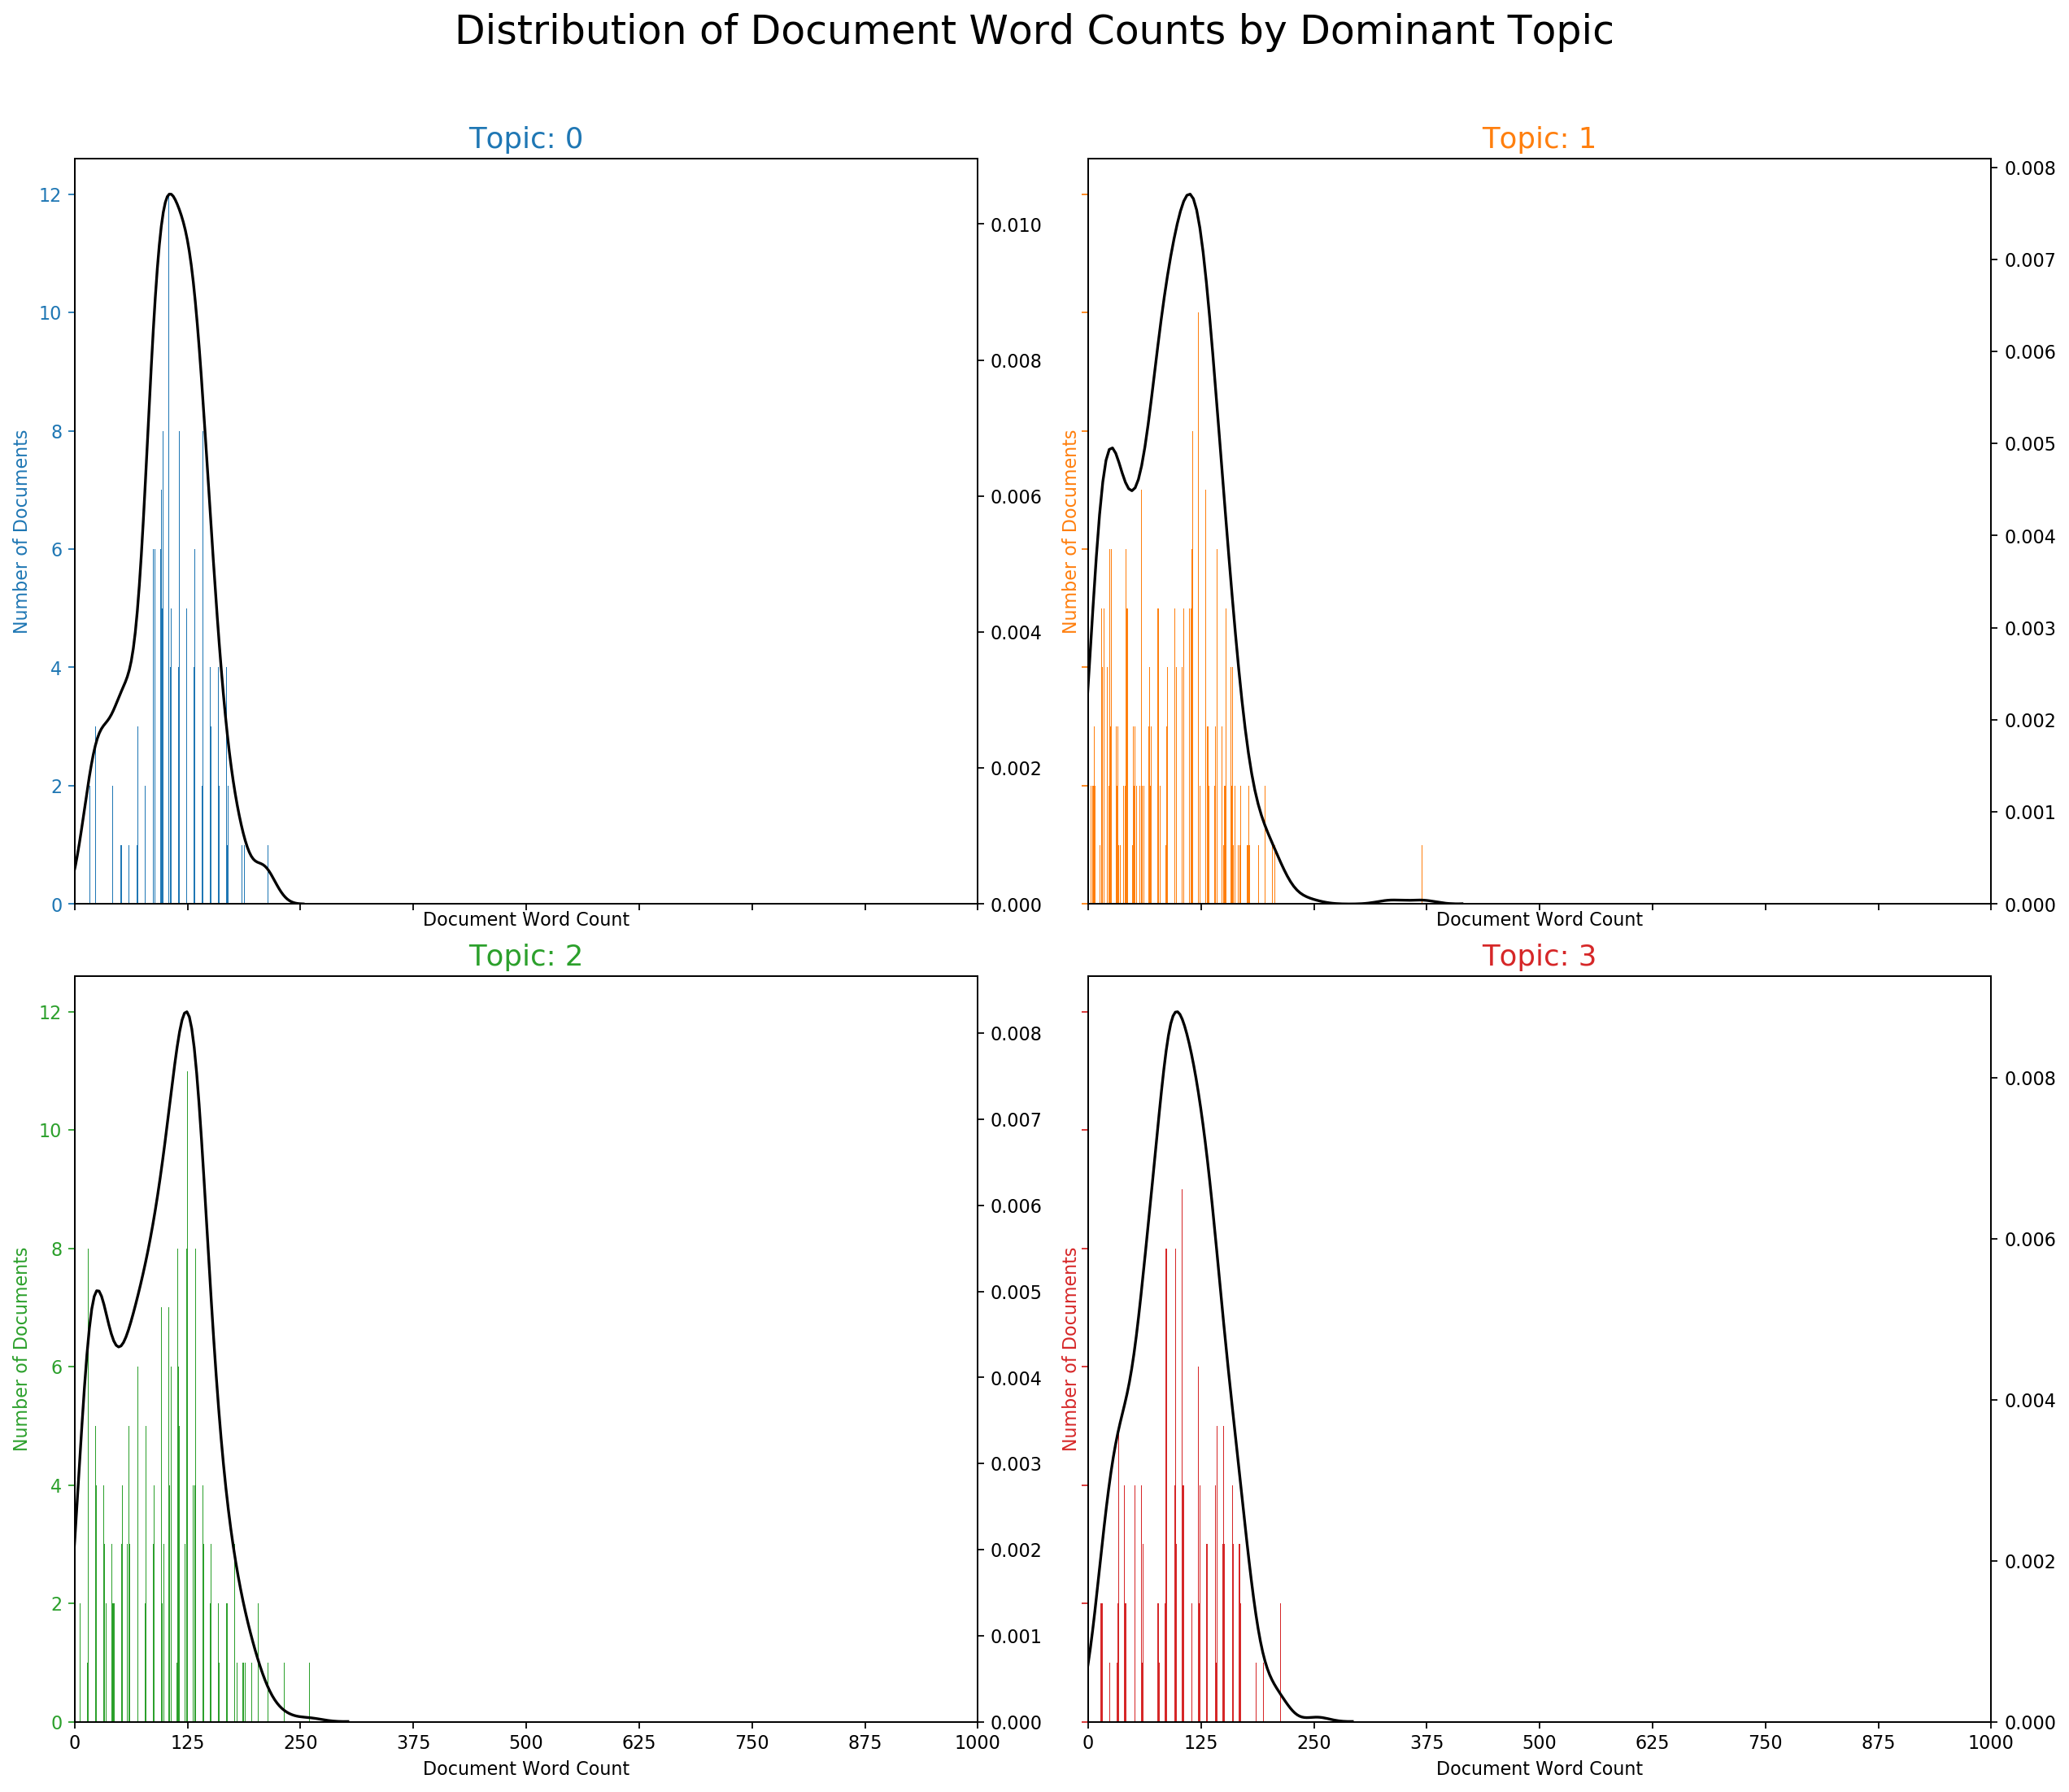

In [0]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Word Clouds of Top N Keywords in Each Topic

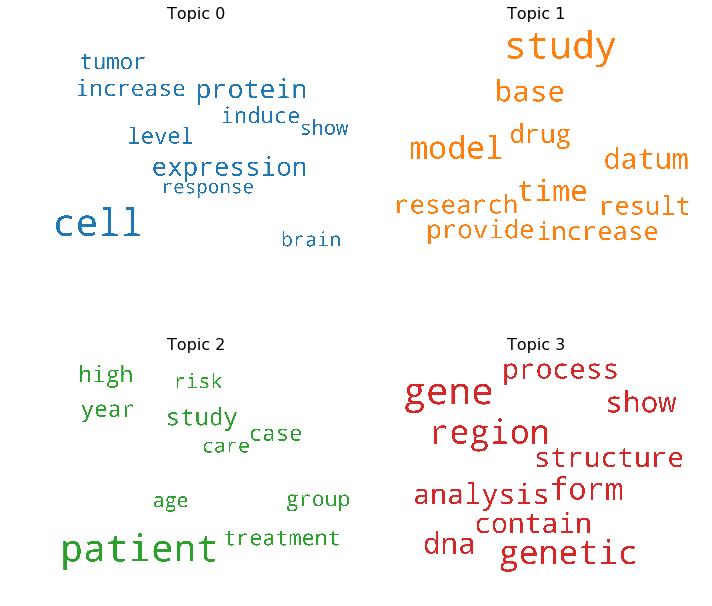

In [0]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

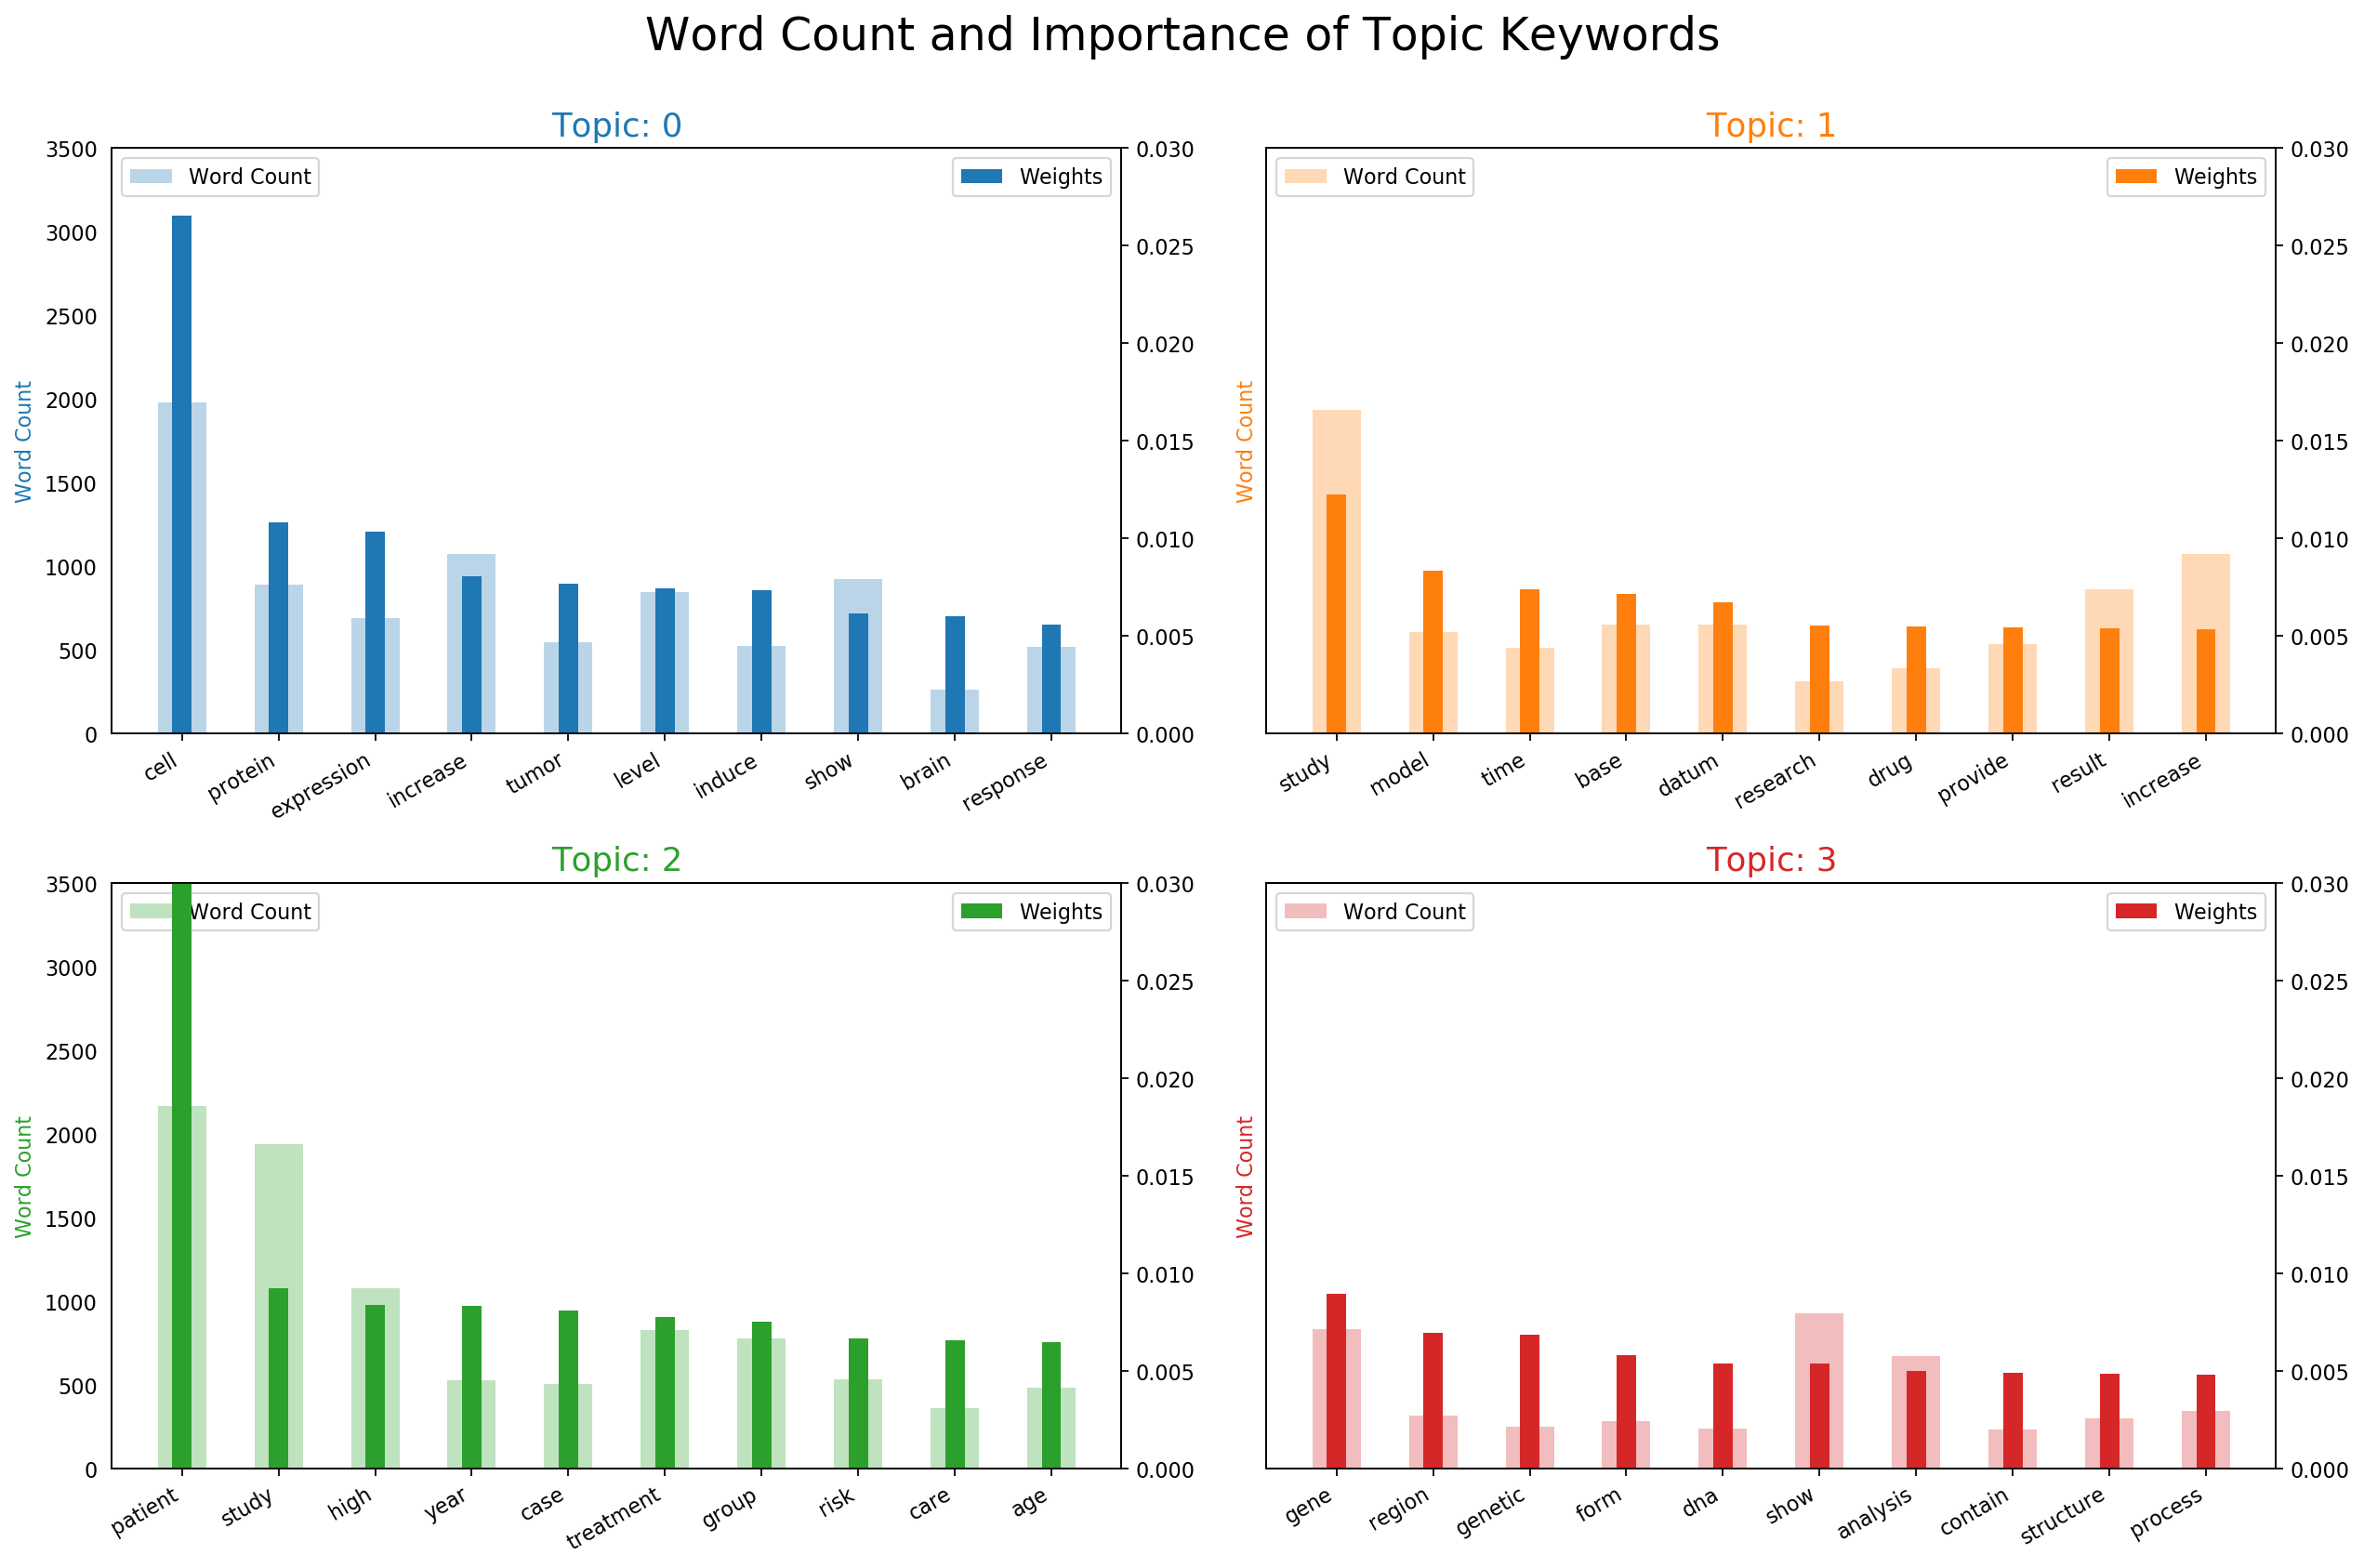

In [0]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Sentence Chart Colored by Topic

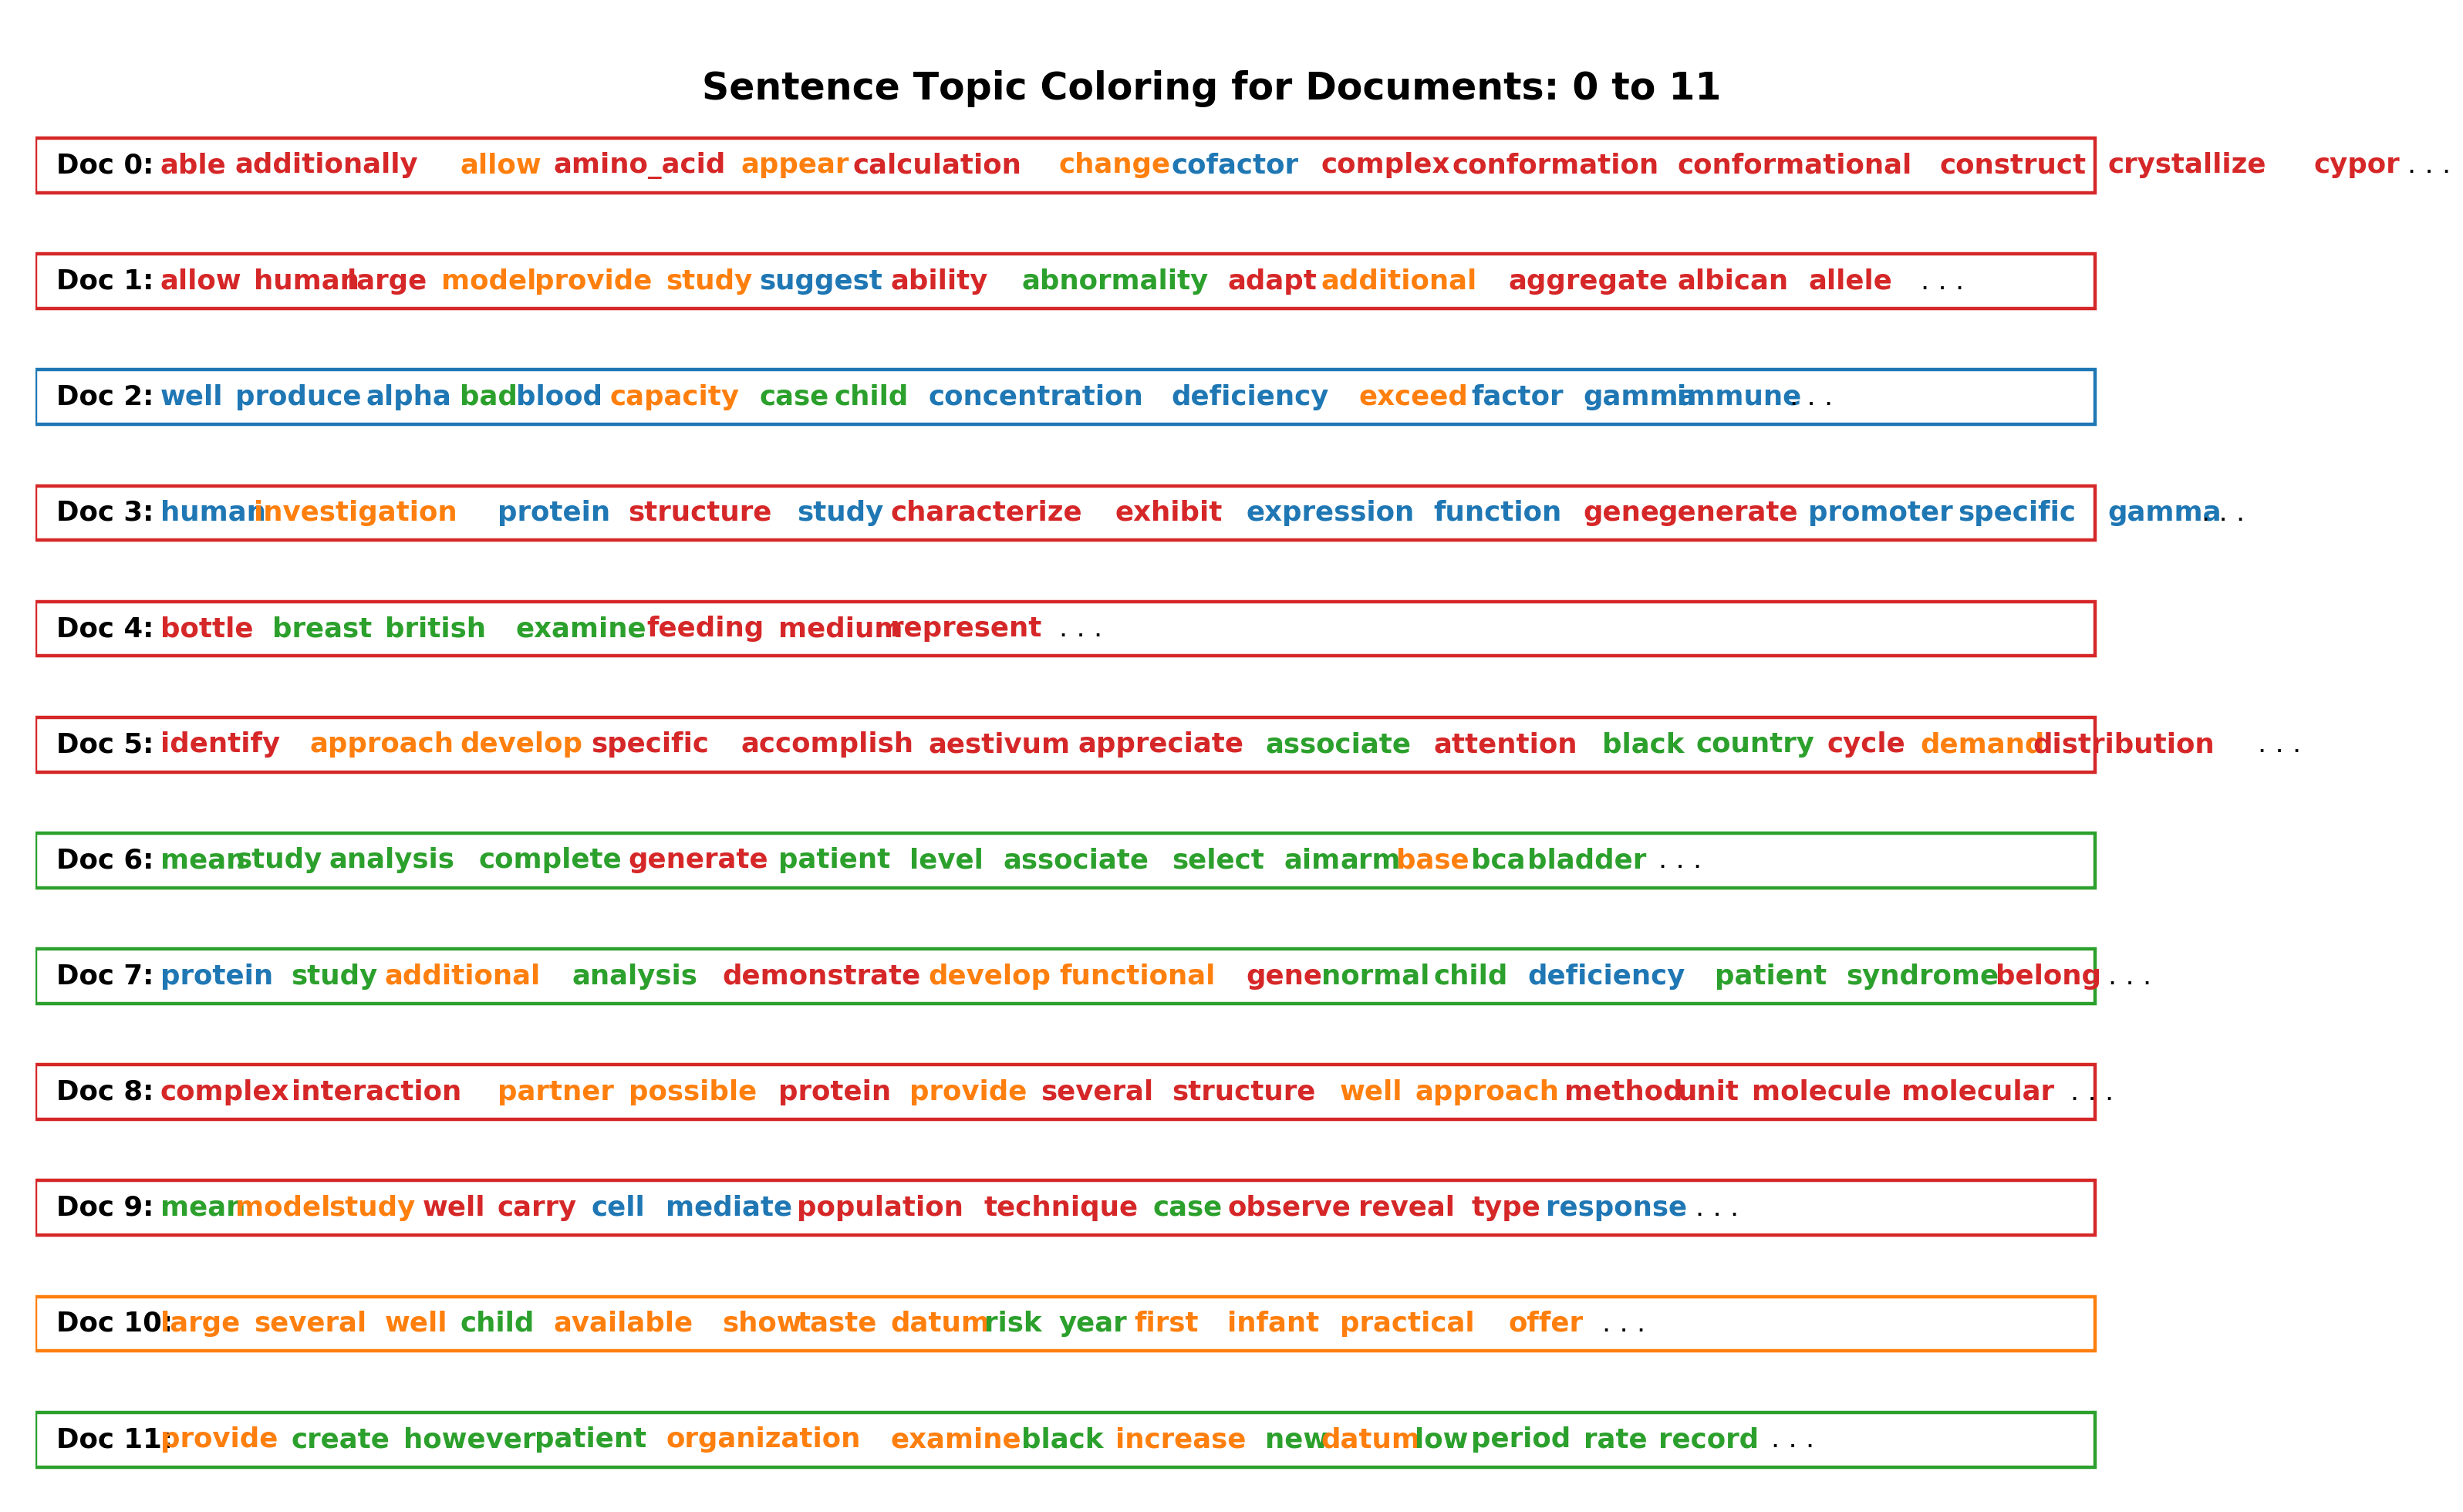

In [0]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

# What are the most discussed topics in the documents?

In [0]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

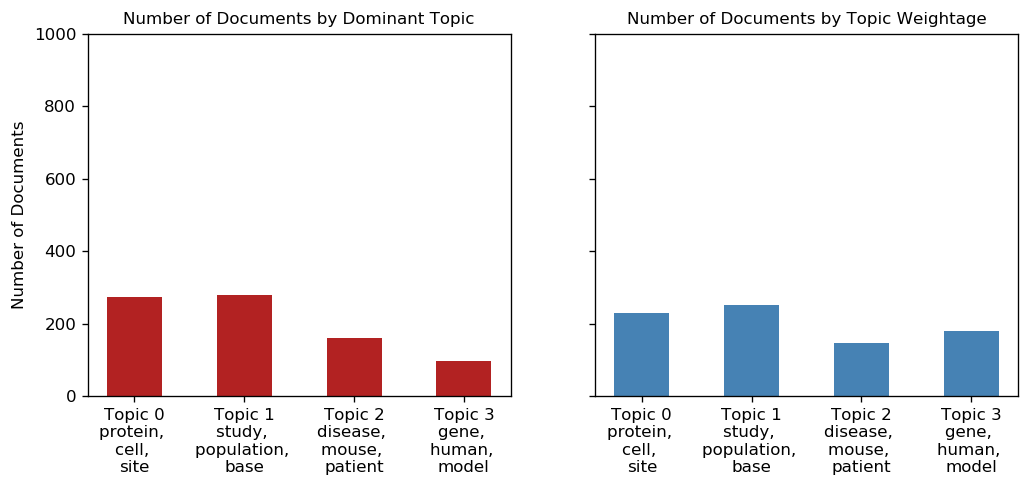

In [0]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# t-SNE Clustering Chart

In [0]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2502 samples in 0.077s...
[t-SNE] Computed neighbors for 2502 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2502
[t-SNE] Computed conditional probabilities for sample 2000 / 2502
[t-SNE] Computed conditional probabilities for sample 2502 / 2502
[t-SNE] Mean sigma: 0.046808
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.746635
[t-SNE] KL divergence after 1000 iterations: 0.753030


Loading BokehJS ...

# pyLDAVis

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\Divya\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.173503 -0.225226       1        1  29.815018
2     -0.166402  0.233022       2        1  24.961645
0      0.136412 -0.019146       3        1  23.470228
3      0.203492  0.011351       4        1  21.753103, topic_info=     Category         Freq           Term        Total  loglift  logprob
168   Default  2174.000000        patient  2174.000000  30.0000  30.0000
71    Default  1574.000000           cell  1574.000000  29.0000  29.0000
91    Default   613.000000     expression   613.000000  28.0000  28.0000
38    Default   884.000000        protein   884.000000  27.0000  27.0000
378   Default   526.000000           year   526.000000  26.0000  26.0000
446   Default   556.000000           time   556.000000  25.0000  25.0000
98    Default   784.000000           gene   784.000000  24.0000  24.0000
1404  Default   456.000000          tumor   456.000000  23.0000  23.0000
305   Default   540.000000           base   540.000000  22.0000  22.0000
742   Default   436.000000         induce   436.000000  21.0000  21.0000
153   Default   545.000000           case   545.000000  20.0000  20.0000
29    Default   689.000000          model   689.000000  19.0000  19.0000
212   Default   806.000000          level   806.000000  18.0000  18.0000
364   Default   419.000000           risk   419.000000  17.0000  17.0000
225   Default   380.000000         region   380.000000  16.0000  16.0000
460   Default   413.000000           care   413.000000  15.0000  15.0000
412   Default   375.000000        genetic   375.000000  14.0000  14.0000
448   Default   621.000000      treatment   621.000000  13.0000  13.0000
1097  Default   386.000000        outcome   386.000000  12.0000  12.0000
183   Default   358.000000          brain   358.000000  11.0000  11.0000
487   Default   720.000000          group   720.000000  10.0000  10.0000
312   Default   366.000000       clinical   366.000000   9.0000   9.0000
526   Default   419.000000       research   419.000000   8.0000   8.0000
979   Default   413.000000           drug   413.000000   7.0000   7.0000
319   Default   544.000000          datum   544.000000   6.0000   6.0000
904   Default   462.000000            age   462.000000   5.0000   5.0000
6     Default   391.000000         change   391.000000   4.0000   4.0000
154   Default   335.000000          child   335.000000   3.0000   3.0000
1221  Default   314.000000       mutation   314.000000   2.0000   2.0000
1775  Default   296.000000            dna   296.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
432    Topic4   102.673927   polymorphism   103.433197   1.5180  -6.2833
1202   Topic4    97.530472        cluster    98.259117   1.5180  -6.3347
1589   Topic4    95.948524        dynamic    96.680473   1.5178  -6.3510
5836   Topic4   141.019730            atp   142.398819   1.5157  -5.9659
5547   Topic4   113.637779       feedback   114.666672   1.5164  -6.1818
2620   Topic4   108.910080         native   110.173035   1.5139  -6.2243
7176   Topic4   100.816879            dry   101.713722   1.5166  -6.3015
136    Topic4   246.713547           site   272.745911   1.4251  -5.4066
94     Topic4   318.212677           form   363.517975   1.3923  -5.1521
60     Topic4   145.774658        albican   154.720474   1.4659  -5.9328
2668   Topic4   176.597260       compound   198.065994   1.4107  -5.7410
1301   Topic4   263.884399        process   338.877350   1.2753  -5.3393
98     Topic4   489.888519           gene   784.563965   1.0545  -4.7207
99     Topic4   190.897476       generate   229.608978   1.3408  -5.6631
791    Topic4   238.483704           bind   318.541870   1.2360  -5.4405
590    Topic4   136.952408          noise   147.775986   1.4493  -5.9952
8      Topic4   203.254822        complex   275.785217   1.2203  -5.6004
276    Topic4   258.518005            new   440.901917  

# Correlation

In [0]:
#Correlation Code
#Import csv generated for dominat topics.. Generate separate csv file for titles
dataset = pd.read_csv('C:\\Users\\Divya\\Desktop\\Datafiles\\test\\Correlation_topics.csv')
popular_topics_set=set()
#Taking only first words as topic
for i in range(2577):
    popular_topics_set.add(dataset['Keywords'][i].split(',')[0])

#popular_topics_set = set(dataset['Dominant_Topic'])
#same dataset but for graphs we modified data frame before

data = pd.read_csv('C:\\Users\\Divya\\Desktop\\Datafiles\\test\\testing')#csv generated from dataset
df = pd.DataFrame(data, columns= ['Title','Abstract'])
popular_topics_set

{'age',
 'association',
 'case',
 'cell',
 'day',
 'drug',
 'examine',
 'exposure',
 'gene',
 'group',
 'induce',
 'infection',
 'new',
 'patient',
 'process',
 'protein',
 'sample',
 'set',
 'status'}

In [0]:
# make new dataframe
topic_vector_df = df.loc[:, ['Abstract']]#Replace with 'Title' for Correlation of topics for titles
for topic in popular_topics_set:
    # make columns to encode presence of hashtags
    topic_vector_df['{}'.format(topic)] = df.Abstract.apply(
        lambda topic_list: int(topic in topic_list))
topic_vector_df

,Abstract,association,infection,cell,protein,examine,group,patient,process,set,gene,sample,case,status,age,new,exposure,drug,induce,day
0,Cytochrome P450 reductase (CYPOR) undergoes a large conformational change to allow for an electr...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
1,The yeast Candida albicans is the most important fungal pathogen of humans and a model organism ...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,The capacity of the peripheral blood mononuclears to produce leukocyte (alpha) and immune (gamma...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,Gamma-butyrobetaine hydroxylase (BBOX1) is the enzyme responsible for the biosynthesis of l-carn...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,To examine how breast feeding and bottle feeding are represented by the British media.,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Truffles are hypogeous fungi which live in symbiosis with plant host roots in order to accomplis...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,Level I evidence supports the utility of neoadjuvant cisplatin-based chemotherapy (NAC) for musc...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
7,"The most common medical conditions in infants, which belong to pediatric and gastroenterological...",0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1
8,Quantum.Ligand.Dock (protein-ligand docking with graphic processing unit (GPU) quantum entanglem...,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
9,Channel noise is the dominant intrinsic noise source of neurons causing variability in the timin...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [0]:
#topic_vector_df

In [0]:
correlations=topic_vector_df.corr(method='pearson')

In [0]:
correlations

,role,development,human,control,cell,receptor,health,activity,treatment,disease,patient,induce,function,carcinoma,study,novel,increase,brain,drug,protein
role,1.000000,0.095849,0.066467,0.065873,0.185336,0.167397,-0.015142,0.108518,0.020142,0.047105,-0.040100,0.133790,0.147553,0.017670,-0.013612,0.052023,0.092146,0.026799,0.038682,0.139936
development,0.095849,1.000000,0.079094,0.035289,0.100035,0.022728,-0.021347,0.012179,-0.013899,0.027790,-0.051219,0.039204,0.069768,0.004538,-0.012628,0.062887,0.052472,0.065845,0.071034,0.076899
human,0.066467,0.079094,1.000000,-0.025244,0.196311,0.126674,0.014901,0.061064,-0.002043,0.019056,-0.097630,0.131448,0.063296,0.034486,0.002923,0.053432,0.038665,0.041307,0.052744,0.174403
control,0.065873,0.035289,-0.025244,1.000000,0.031206,0.024372,0.085271,0.028037,0.046272,0.029474,0.036467,0.061436,0.079332,0.005547,0.083461,0.005198,0.079317,0.042907,0.004328,0.025408
cell,0.185336,0.100035,0.196311,0.031206,1.000000,0.223937,-0.137342,0.161318,0.093479,0.046789,-0.068597,0.258212,0.155558,0.166894,-0.044046,0.123020,0.122243,0.059220,0.085325,0.297726
receptor,0.167397,0.022728,0.126674,0.024372,0.223937,1.000000,-0.038408,0.113704,0.050645,0.028507,-0.027804,0.175029,0.111395,-0.009972,-0.032799,0.065987,0.101301,0.050097,0.068855,0.177388
health,-0.015142,-0.021347,0.014901,0.085271,-0.137342,-0.038408,1.000000,-0.053486,0.000085,0.076143,0.095485,-0.061997,-0.010509,-0.041844,0.116895,-0.038492,0.015373,-0.024746,-0.022485,-0.086045
activity,0.108518,0.012179,0.061064,0.028037,0.161318,0.113704,-0.053486,1.000000,-0.001490,-0.018175,-0.069341,0.149544,0.123265,0.010340,0.017021,0.009702,0.106681,0.047138,0.026424,0.161570
treatment,0.020142,-0.013899,-0.002043,0.046272,0.093479,0.050645,0.000085,-0.001490,1.000000,0.102885,0.223899,0.083447,-0.000808,0.043685,0.032229,0.034868,0.089958,-0.008357,0.166792,-0.055936
disease,0.047105,0.027790,0.019056,0.029474,0.046789,0.028507,0.076143,-0.018175,0.102885,1.000000,0.162810,0.013808,0.037488,0.064247,0.024374,0.005317,0.017010,0.058791,0.016767,0.004425


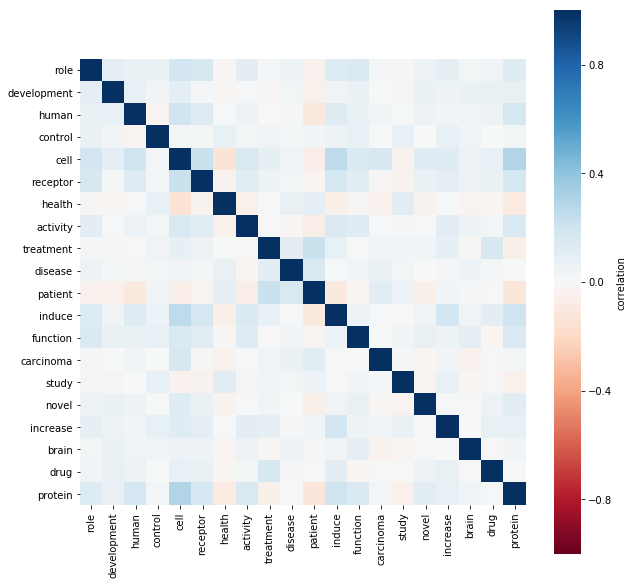

In [0]:
# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

#Summary

In this project, we built an LDA topic model and we have shown several preprocessing steps done before building the model i.e. steps like removing stop words, tokenization ,lemmatization. Then, after the model is built  we found the topics manually by seeing the keywords obtained from the topic model. A limitation of LDA is its inability to find the topic correlation. We have found the correlation among topics by extracting both the abstracts and titles from the dataset. We have shown multiple ways to visualize the data. This model can be implemented using large amount of data than we used, and the results might vary for the correlation. This model can be improved by using Mallet’s version of LDA algorithm